c:\Users\roshi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\roshi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction 

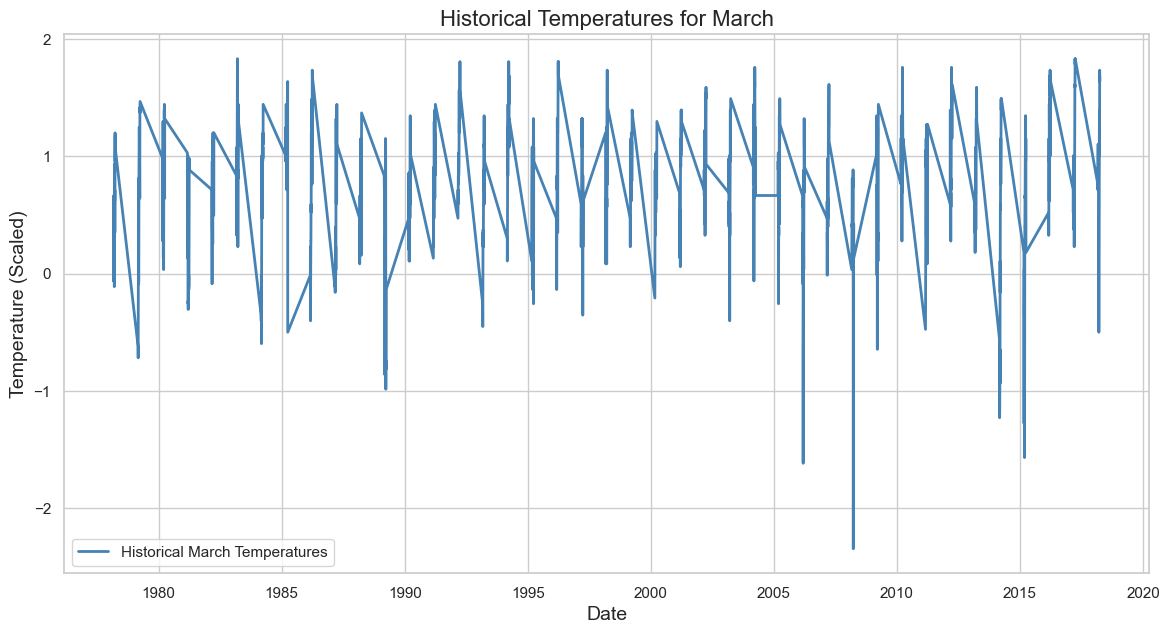

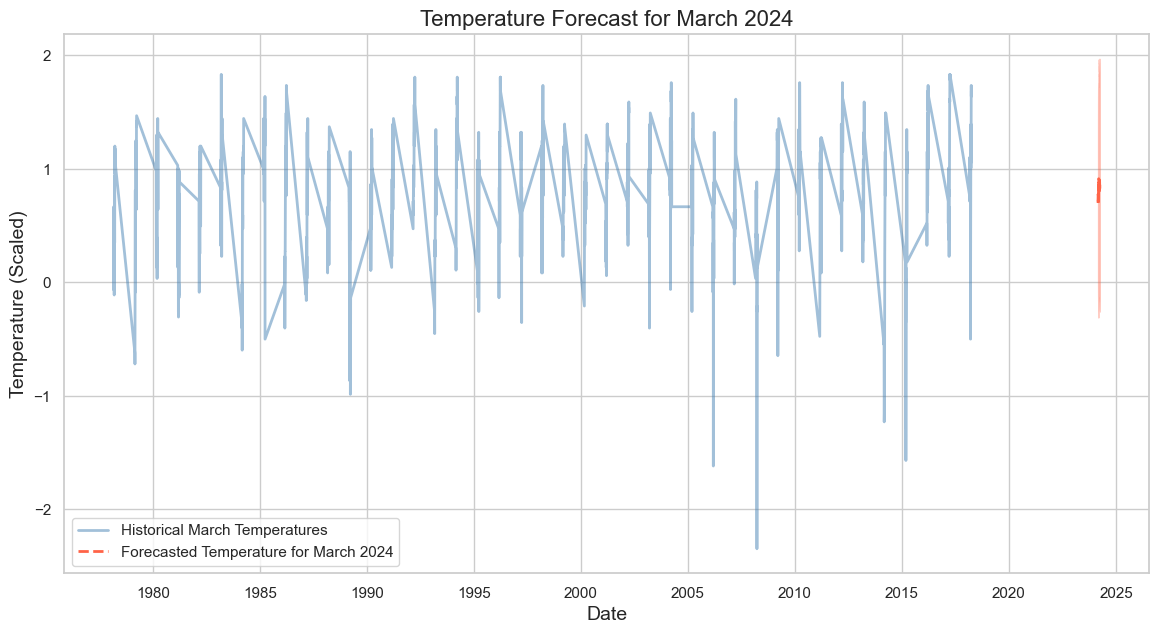

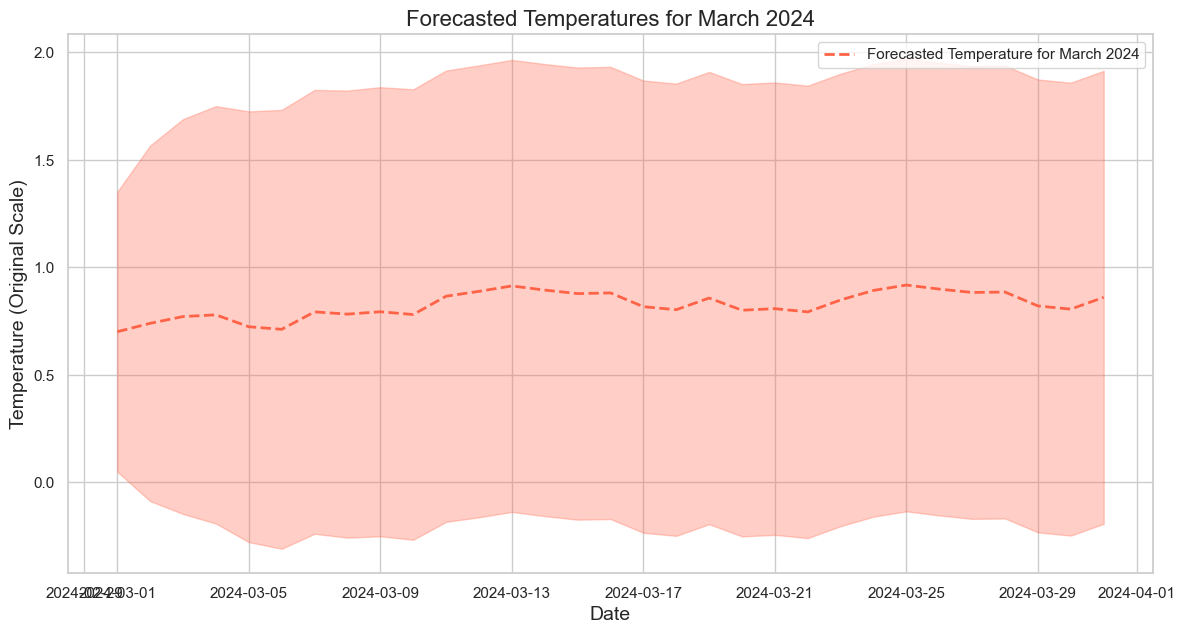

Best MAE: 0.32
Best MSE: 0.17
Best RMSE: 0.41
Average Forecasted Temperature: 35.45
Average Historical Temperature for March: 35.20


In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
from sklearn.feature_selection import SelectKBest, f_regression

# Load your dataset
data = pd.read_excel(r'D:\PROJECT\ML Project\new one\ICRISAT Weather 1978 to 2018.xlsx')

# Preprocessing
data['Date'] = pd.to_datetime(data['Date'])
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year
data['Day'] = data['Date'].dt.day
data['Day_of_Year'] = data['Date'].dt.dayofyear
data['Week_of_Year'] = data['Date'].dt.isocalendar().week

# Feature Engineering
data['Month_Sin'] = np.sin(2 * np.pi * data['Month'] / 12.0)
data['Month_Cos'] = np.cos(2 * np.pi * data['Month'] / 12.0)
data['Day_Sin'] = np.sin(2 * np.pi * data['Day'] / 365.0)
data['Day_Cos'] = np.cos(2 * np.pi * data['Day'] / 365.0)

# Scaling the temperature data
scaler = StandardScaler()
data['MaxT'] = scaler.fit_transform(data[['MaxT']])

# Take user input for the month and year
user_month = input("Enter the month (e.g., January, February, etc.): ")
user_year = int(input("Enter the year: "))

# Convert the user input month to a numerical value
month_map = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
}
user_month_num = month_map.get(user_month)

# Validate user input
if user_month_num is None:
    raise ValueError("Invalid month input. Please enter a valid month name.")

# Filtering only the user-specified month and year data
user_data = data[(data['Month'] == user_month_num) & (data['Year'] == user_year)]
temperature = user_data.set_index('Date')['MaxT']

# Set the seaborn style for better aesthetics
sns.set(style="whitegrid")

# If there is no data for the specified month and year
if temperature.empty:
    # Use data from the specified month across all years for model training
    month_data = data[data['Month'] == user_month_num]
    month_temp = month_data.set_index('Date')['MaxT']
    features = month_data[['Month_Sin', 'Month_Cos', 'Day_Sin', 'Day_Cos']]

    # Feature Selection
    selector = SelectKBest(score_func=f_regression, k='all')
    features_selected = selector.fit_transform(features, month_temp)
    
    # Split the data into training and testing sets using TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)
    best_rmse = float('inf')
    best_model = None
    best_mae = float('inf')
    best_mse = float('inf')

    for train_index, test_index in tscv.split(month_temp):
        train, test = month_temp.iloc[train_index], month_temp.iloc[test_index]
        train_features, test_features = features_selected[train_index], features_selected[test_index]

        # Build the SARIMAX model for temperature
        model_temp = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
        model_temp_fit = model_temp.fit(disp=False)

        # Evaluate the model
        forecast = model_temp_fit.get_forecast(steps=len(test))
        forecast_mean = forecast.predicted_mean
        mse = mean_squared_error(test, forecast_mean)
        mae = mean_absolute_error(test, forecast_mean)
        rmse = np.sqrt(mse)

        if rmse < best_rmse:
            best_rmse = rmse
            best_mae = mae
            best_mse = mse
            best_model = model_temp_fit

    # Save the best model for reuse
    with open('temperature_model.pkl', 'wb') as temp_model_file:
        pickle.dump(best_model, temp_model_file)

    # Forecast for the entire specified month in the user-provided year
    forecast_dates = pd.date_range(start=f'{user_year}-{user_month_num:02d}-01', end=f'{user_year}-{user_month_num:02d}-{pd.Timestamp(year=user_year, month=user_month_num, day=1).days_in_month}')

    # Prepare features for the forecast dates
    future_features = pd.DataFrame({
        'Month_Sin': np.sin(2 * np.pi * user_month_num / 12.0),
        'Month_Cos': np.cos(2 * np.pi * user_month_num / 12.0),
        'Day_Sin': [np.sin(2 * np.pi * day / 365.0) for day in range(1, len(forecast_dates) + 1)],
        'Day_Cos': [np.cos(2 * np.pi * day / 365.0) for day in range(1, len(forecast_dates) + 1)],
    }, index=forecast_dates)

    forecast = best_model.get_forecast(steps=len(forecast_dates))
    forecast_mean = forecast.predicted_mean
    forecast_conf_int = forecast.conf_int()

    # Inverse transform the forecasted temperatures to original scale
    forecast_mean_original = scaler.inverse_transform(forecast_mean.values.reshape(-1, 1))
    average_temp = forecast_mean_original.mean()

    # Inverse transform historical data to original scale
    month_temp_original = scaler.inverse_transform(month_temp.values.reshape(-1, 1))
    avg_historical_temp = month_temp_original.mean()

    # Plot the historical temperatures for the specified month
    plt.figure(figsize=(14, 7))
    plt.plot(month_temp.index, month_temp.values, label=f'Historical {user_month} Temperatures', color='steelblue', linestyle='-', linewidth=2)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Temperature (Scaled)', fontsize=14)
    plt.title(f'Historical Temperatures for {user_month}', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot the forecasted temperatures for the specified month and year
    plt.figure(figsize=(14, 7))
    plt.plot(month_temp.index, month_temp.values, label=f'Historical {user_month} Temperatures', color='steelblue', linestyle='-', linewidth=2, alpha=0.5)
    plt.plot(forecast_dates, forecast_mean, label=f'Forecasted Temperature for {user_month} {user_year}', color='tomato', linestyle='--', linewidth=2)
    plt.fill_between(forecast_dates, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='tomato', alpha=0.3)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Temperature (Scaled)', fontsize=14)
    plt.title(f'Temperature Forecast for {user_month} {user_year}', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot the forecasted temperatures only for the specified month
    plt.figure(figsize=(14, 7))
    plt.plot(forecast_dates, forecast_mean, label=f'Forecasted Temperature for {user_month} {user_year}', color='tomato', linestyle='--', linewidth=2)
    plt.fill_between(forecast_dates, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='tomato', alpha=0.3)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Temperature (Original Scale)', fontsize=14)
    plt.title(f'Forecasted Temperatures for {user_month} {user_year}', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print evaluation metrics and temperatures
    print(f'Best MAE: {best_mae:.2f}')
    print(f'Best MSE: {best_mse:.2f}')
    print(f'Best RMSE: {best_rmse:.2f}')
    print(f'Average Forecasted Temperature: {average_temp:.2f}')
    print(f'Average Historical Temperature for {user_month}: {avg_historical_temp:.2f}')
else:
    # Inverse transform the user data if it exists
    temperature_original = scaler.inverse_transform(temperature.values.reshape(-1, 1))
    avg_temperature = temperature_original.mean()

    # Plot the data directly if it exists for the given month and year
    plt.figure(figsize=(14, 7))
    plt.plot(temperature.index, temperature.values, label=f'{user_month} {user_year} Temperatures', color='forestgreen', linestyle='-', linewidth=2)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Temperature (Scaled)', fontsize=14)
    plt.title(f'{user_month} {user_year} Temperatures', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print average temperature for the existing data
    print(f'Average Temperature for {user_month} {user_year}: {avg_temperature:.2f}')


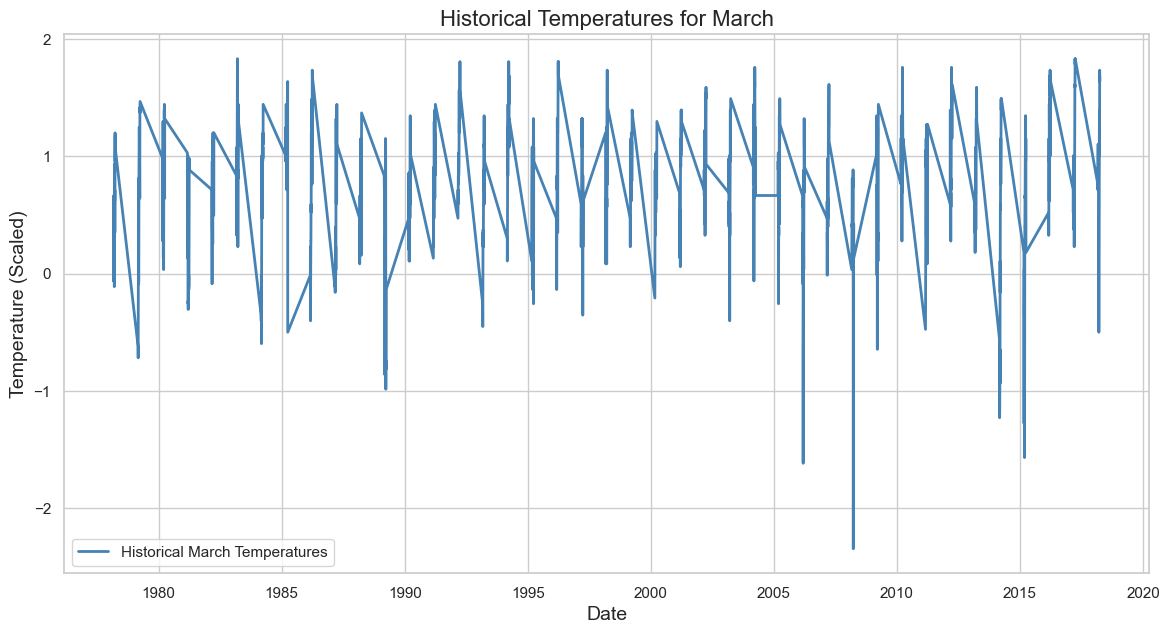

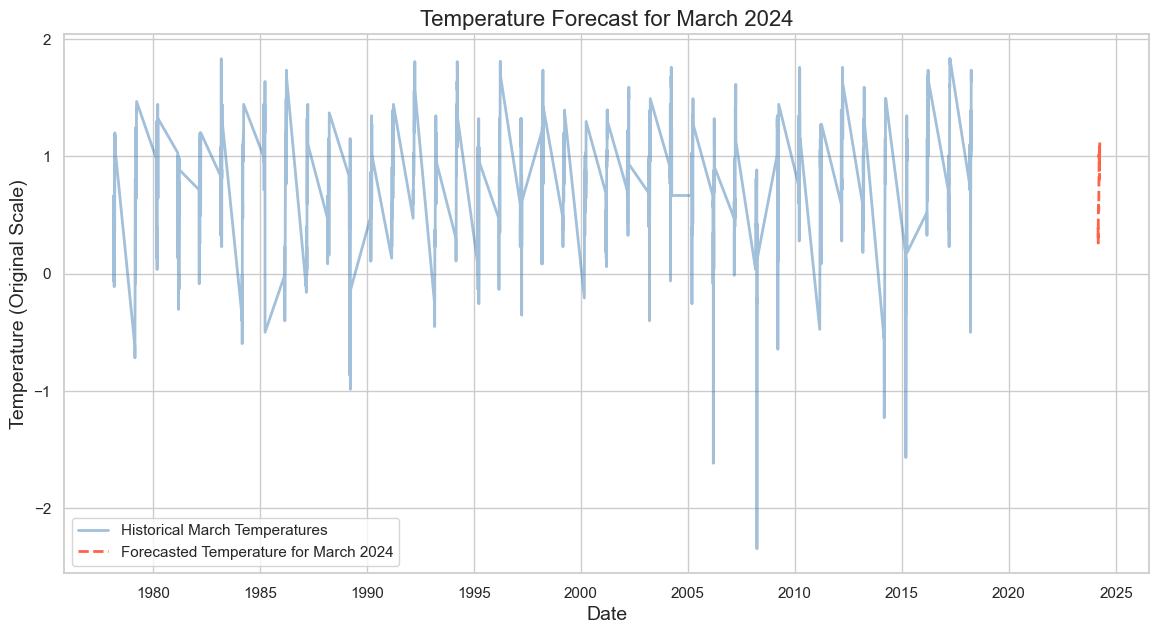

Best MAE: 0.30
Best MSE: 0.13
Best RMSE: 0.37
Average Forecasted Temperature: 35.13
Average Historical Temperature for March: 35.20


In [3]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SelectKBest, f_regression
import xgboost as xgb
from datetime import datetime  # Add this import

# Load your dataset
try:
    data = pd.read_excel(r'D:\PROJECT\ML Project\new one\ICRISAT Weather 1978 to 2018.xlsx')
except FileNotFoundError:
    raise FileNotFoundError("The dataset file was not found. Please check the file path.")

# Preprocessing
data['Date'] = pd.to_datetime(data['Date'])
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year
data['Day'] = data['Date'].dt.day
data['Day_of_Year'] = data['Date'].dt.dayofyear
data['Week_of_Year'] = data['Date'].dt.isocalendar().week

# Feature Engineering
data['Month_Sin'] = np.sin(2 * np.pi * data['Month'] / 12.0)
data['Month_Cos'] = np.cos(2 * np.pi * data['Month'] / 12.0)
data['Day_Sin'] = np.sin(2 * np.pi * data['Day'] / 365.0)
data['Day_Cos'] = np.cos(2 * np.pi * data['Day'] / 365.0)

# Scaling the temperature data
scaler = StandardScaler()
data['MaxT'] = scaler.fit_transform(data[['MaxT']])
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Take user input for the month and year
user_month = input("Enter the month (e.g., January, February, etc.): ")
user_year = int(input("Enter the year: "))

# Convert the user input month to a numerical value
month_map = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
}
user_month_num = month_map.get(user_month)

# Validate user input
if user_month_num is None or user_year < 1900 or user_year > datetime.now().year:
    raise ValueError("Invalid month or year input. Please enter a valid month and year.")

# Filtering data for user-specified month and year
user_data = data[(data['Month'] == user_month_num) & (data['Year'] == user_year)]
temperature = user_data.set_index('Date')['MaxT']

sns.set(style="whitegrid")

if temperature.empty:
    # Use data from the specified month across all years for model training
    month_data = data[data['Month'] == user_month_num]
    month_temp = month_data.set_index('Date')['MaxT']
    features = month_data[['Month_Sin', 'Month_Cos', 'Day_Sin', 'Day_Cos']]

    # Feature Selection
    selector = SelectKBest(score_func=f_regression, k='all')
    features_selected = selector.fit_transform(features, month_temp)
    
    # Split the data into training and testing sets using TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)
    best_rmse = float('inf')
    best_model = None
    best_mae = float('inf')
    best_mse = float('inf')

    for train_index, test_index in tscv.split(month_temp):
        train, test = month_temp.iloc[train_index], month_temp.iloc[test_index]
        train_features, test_features = features_selected[train_index], features_selected[test_index]

        # Train the XGBoost model
        xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1)
        xgb_model.fit(train_features, train)

        # Evaluate the model
        forecast = xgb_model.predict(test_features)
        mse = mean_squared_error(test, forecast)
        mae = mean_absolute_error(test, forecast)
        rmse = np.sqrt(mse)

        if rmse < best_rmse:
            best_rmse = rmse
            best_mae = mae
            best_mse = mse
            best_model = xgb_model

    # Save the best model for reuse
    with open('temperature_xgb_model.pkl', 'wb') as xgb_model_file:
        pickle.dump(best_model, xgb_model_file)

    # Forecast for the entire specified month in the user-provided year
    forecast_dates = pd.date_range(start=f'{user_year}-{user_month_num:02d}-01', end=f'{user_year}-{user_month_num:02d}-{pd.Timestamp(year=user_year, month=user_month_num, day=1).days_in_month}')
    future_features = pd.DataFrame({
        'Month_Sin': np.sin(2 * np.pi * user_month_num / 12.0),
        'Month_Cos': np.cos(2 * np.pi * user_month_num / 12.0),
        'Day_Sin': [np.sin(2 * np.pi * day / 365.0) for day in range(1, len(forecast_dates) + 1)],
        'Day_Cos': [np.cos(2 * np.pi * day / 365.0) for day in range(1, len(forecast_dates) + 1)],
    }, index=forecast_dates)

    forecast = best_model.predict(future_features)
    forecast_mean = forecast
    forecast_mean_original = scaler.inverse_transform(forecast_mean.reshape(-1, 1))
    average_temp = forecast_mean_original.mean()

    # Inverse transform historical data to original scale
    month_temp_original = scaler.inverse_transform(month_temp.values.reshape(-1, 1))
    avg_historical_temp = month_temp_original.mean()

    # Plot the historical temperatures for the specified month
    plt.figure(figsize=(14, 7))
    plt.plot(month_temp.index, month_temp.values, label=f'Historical {user_month} Temperatures', color='steelblue', linestyle='-', linewidth=2)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Temperature (Scaled)', fontsize=14)
    plt.title(f'Historical Temperatures for {user_month}', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot the forecasted temperatures for the specified month and year
    plt.figure(figsize=(14, 7))
    plt.plot(month_temp.index, month_temp.values, label=f'Historical {user_month} Temperatures', color='steelblue', linestyle='-', linewidth=2, alpha=0.5)
    plt.plot(forecast_dates, forecast_mean, label=f'Forecasted Temperature for {user_month} {user_year}', color='tomato', linestyle='--', linewidth=2)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Temperature (Original Scale)', fontsize=14)
    plt.title(f'Temperature Forecast for {user_month} {user_year}', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print evaluation metrics and temperatures
    print(f'Best MAE: {best_mae:.2f}')
    print(f'Best MSE: {best_mse:.2f}')
    print(f'Best RMSE: {best_rmse:.2f}')
    print(f'Average Forecasted Temperature: {average_temp:.2f}')
    print(f'Average Historical Temperature for {user_month}: {avg_historical_temp:.2f}')
else:
    # Inverse transform the user data if it exists
    temperature_original = scaler.inverse_transform(temperature.values.reshape(-1, 1))
    avg_temperature = temperature_original.mean()

    # Plot the data directly if it exists for the given month and year
    plt.figure(figsize=(14, 7))
    plt.plot(temperature.index, temperature.values, label=f'{user_month} {user_year} Temperatures', color='forestgreen', linestyle='-', linewidth=2)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Temperature (Scaled)', fontsize=14)
    plt.title(f'{user_month} {user_year} Temperatures', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print average temperature for the existing data
    print(f'Average Temperature for {user_month} {user_year}: {avg_temperature:.2f}')


c:\Users\roshi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 34s 23ms/step - loss: 0.0386
Epoch 2/20
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - loss: 0.0135
Epoch 3/20
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - loss: 0.0121
Epoch 4/20
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - loss: 0.0084
Epoch 5/20
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - loss: 0.0085
Epoch 6/20
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - loss: 0.0077
Epoch 7/20
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - loss: 0.0085
Epoch 8/20
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - loss: 0.0072
Epoch 9/20
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - loss: 0.0069
Epoch 10/20
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - loss: 0.0073
Epoch 11/20
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - loss: 0.0072
Epoch 12/20
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - loss: 0.0071
Epoch 13/20
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - loss: 0.0067
Epoch 14/20
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - loss: 0.0079
E

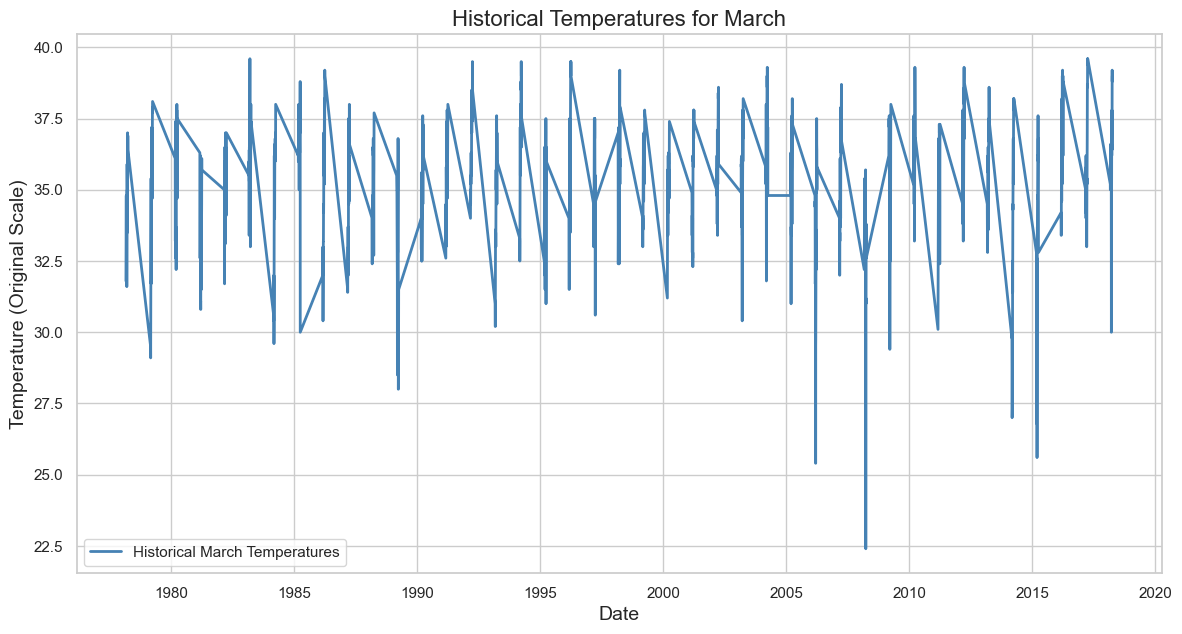

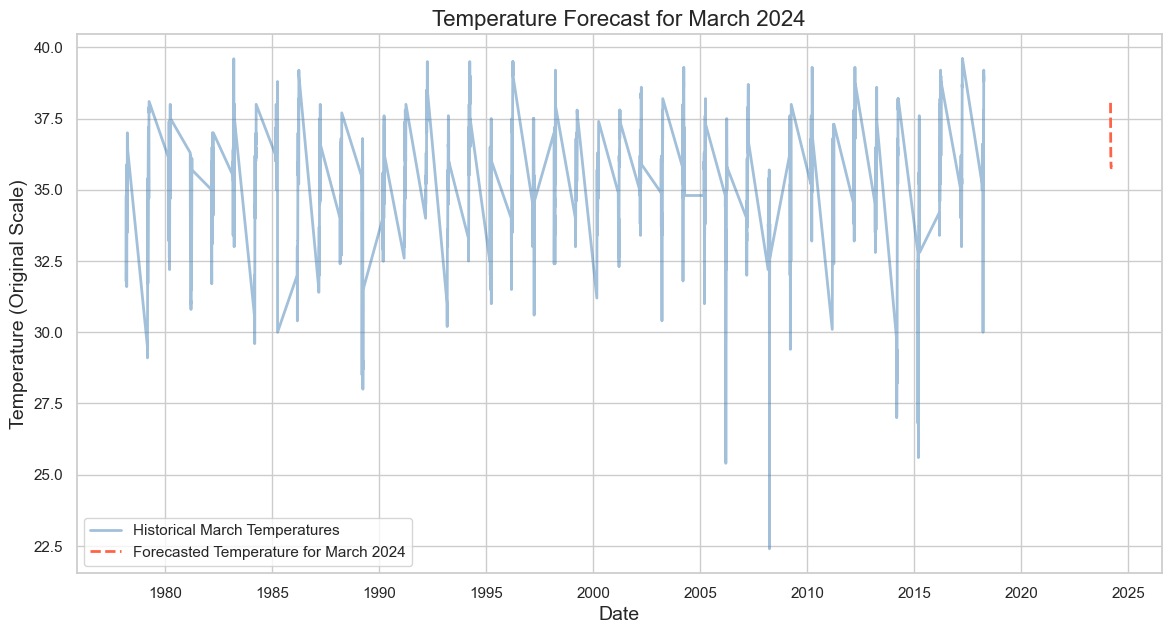

Average Forecasted Temperature: 36.02
Average Historical Temperature for March: 35.20


In [8]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error

# Load your dataset
data = pd.read_excel(r'D:\PROJECT\ML Project\new one\ICRISAT Weather 1978 to 2018.xlsx')

# Preprocessing
data['Date'] = pd.to_datetime(data['Date'])
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year
data['Day'] = data['Date'].dt.day

# Filtering only the user-specified month and year data
user_month = input("Enter the month (e.g., January, February, etc.): ")
user_year = int(input("Enter the year: "))

# Convert the user input month to a numerical value
month_map = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
}
user_month_num = month_map.get(user_month)

# Validate user input
if user_month_num is None:
    raise ValueError("Invalid month input. Please enter a valid month name.")

# Filtering only the user-specified month and year data
user_data = data[(data['Month'] == user_month_num) & (data['Year'] == user_year)]
temperature = user_data.set_index('Date')['MaxT']

# Set the seaborn style for better aesthetics
sns.set(style="whitegrid")

# If there is no data for the specified month and year
if temperature.empty:
    # Use data from the specified month across all years for model training
    month_data = data[data['Month'] == user_month_num]
    month_temp = month_data[['Date', 'MaxT']].set_index('Date')
    
    # Scale data using MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(month_temp)
    
    # Prepare the data for LSTM
    def create_dataset(dataset, look_back=1):
        X, Y = [], []
        for i in range(len(dataset) - look_back - 1):
            a = dataset[i:(i + look_back), 0]
            X.append(a)
            Y.append(dataset[i + look_back, 0])
        return np.array(X), np.array(Y)
    
    look_back = 30  # You can adjust the look_back window
    X, Y = create_dataset(scaled_data, look_back)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape input to be [samples, time steps, features]

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X, Y, batch_size=1, epochs=20)

    # Forecasting for the specified month and year
    forecast_data = []
    last_look_back_data = scaled_data[-look_back:]

    for _ in range(len(pd.date_range(start=f'{user_year}-{user_month_num:02d}-01',
                                     end=f'{user_year}-{user_month_num:02d}-{pd.Timestamp(year=user_year, month=user_month_num, day=1).days_in_month}'))):
        X_input = np.reshape(last_look_back_data, (1, look_back, 1))
        forecast_value = model.predict(X_input)
        forecast_data.append(forecast_value[0, 0])
        last_look_back_data = np.append(last_look_back_data[1:], forecast_value, axis=0)

    # Inverse transform the forecasted data to the original scale
    forecast_data = np.array(forecast_data).reshape(-1, 1)
    forecast_original = scaler.inverse_transform(forecast_data)

    # Inverse transform the original historical data for the same month
    month_temp_original = scaler.inverse_transform(scaled_data)

    # Plot the historical temperatures for the specified month
    plt.figure(figsize=(14, 7))
    plt.plot(month_temp.index, month_temp_original, label=f'Historical {user_month} Temperatures', color='steelblue', linestyle='-', linewidth=2)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Temperature (Original Scale)', fontsize=14)
    plt.title(f'Historical Temperatures for {user_month}', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot the forecasted temperatures for the specified month and year
    forecast_dates = pd.date_range(start=f'{user_year}-{user_month_num:02d}-01',
                                   end=f'{user_year}-{user_month_num:02d}-{pd.Timestamp(year=user_year, month=user_month_num, day=1).days_in_month}')
    
    plt.figure(figsize=(14, 7))
    plt.plot(month_temp.index, month_temp_original, label=f'Historical {user_month} Temperatures', color='steelblue', linestyle='-', linewidth=2, alpha=0.5)
    plt.plot(forecast_dates, forecast_original, label=f'Forecasted Temperature for {user_month} {user_year}', color='tomato', linestyle='--', linewidth=2)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Temperature (Original Scale)', fontsize=14)
    plt.title(f'Temperature Forecast for {user_month} {user_year}', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print average forecasted and historical temperatures
    print(f'Average Forecasted Temperature: {forecast_original.mean():.2f}')
    print(f'Average Historical Temperature for {user_month}: {month_temp_original.mean():.2f}')

else:
    # Inverse transform the user data if it exists
    scaler = MinMaxScaler(feature_range=(0, 1))
    temperature_scaled = scaler.fit_transform(temperature.values.reshape(-1, 1))
    temperature_original = scaler.inverse_transform(temperature_scaled)
    avg_temperature = temperature_original.mean()

    # Plot the data directly if it exists for the given month and year
    plt.figure(figsize=(14, 7))
    plt.plot(temperature.index, temperature_original, label=f'{user_month} {user_year} Temperatures', color='forestgreen', linestyle='-', linewidth=2)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Temperature (Original Scale)', fontsize=14)
    plt.title(f'{user_month} {user_year} Temperatures', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print average temperature for the existing data
    print(f'Average Temperature for {user_month} {user_year}: {avg_temperature:.2f}')


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from datetime import datetime
import joblib

# Load the dataset
df = pd.read_excel(r'D:\PROJECT\ML Project\new one\ICRISAT Weather 1978 to 2018.xlsx')

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Extract features from 'Date'
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

# Define features and target for temperature prediction
features = ['RH1', 'RH2', 'Wind', 'Rain', 'SSH', 'Evap', 'Radiation', 'FAO56_ET', 'Lat', 'Lon', 'Day', 'Month', 'Year']
X = df[features]
y_max_temp = df['MaxT']

# Handle missing values by filling with median values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Split data for regression
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_max_temp, test_size=0.2, random_state=42)

# Train regression model
reg_model = RandomForestRegressor()
reg_model.fit(X_train, y_train)

# Predict and evaluate regression model
y_pred = reg_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

print(f"Regression Mean Squared Error: {mse:.3f}")
print(f"Regression Root Mean Squared Error: {rmse:.3f}")
print(f"Regression R^2 Score: {r2:.3f}")

# Save regression model and imputer
joblib.dump(reg_model, 'regression_model.joblib')
joblib.dump(imputer, 'imputer.joblib')

# Create weather labels based on temperature and rainfall
def create_weather_label(temp, rain):
    """
    Classify weather into categories based on temperature and rainfall.

    Parameters:
    - temp: float, the temperature value in degrees Celsius.
    - rain: float, the amount of rainfall in millimeters.

    Returns:
    - str, the weather category.
    """
    if rain > 0:
        if temp >= 30:
            return 'Hot and Rainy'
        elif 20 <= temp < 30:
            return 'Warm and Rainy'
        elif 10 <= temp < 20:
            return 'Cool and Rainy'
        else:
            return 'Cold and Rainy'
    else:
        if temp >= 30:
            return 'Hot and Dry'
        elif 20 <= temp < 30:
            return 'Warm and Dry'
        elif 10 <= temp < 20:
            return 'Cool and Dry'
        else:
            return 'Cold and Dry'

df['Weather_Type'] = df.apply(lambda row: create_weather_label(row['MaxT'], row['Rain']), axis=1)

# Split data for classification
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_imputed, df['Weather_Type'], test_size=0.2, random_state=42)

# Train classification model
clf_model = RandomForestClassifier()
clf_model.fit(X_train_class, y_train_class)

# Predict and evaluate classification model
y_pred_class = clf_model.predict(X_test_class)
accuracy = accuracy_score(y_test_class, y_pred_class)
class_report = classification_report(y_test_class, y_pred_class)

print(f"Classification Accuracy: {accuracy:.3f}")
print("Classification Report:")
print(class_report)

# Save classification model
joblib.dump(clf_model, 'classification_model.joblib')

# Update dataset with weather type predictions
df['Predicted_Weather_Type'] = clf_model.predict(X_imputed)

# Save the updated dataset with predictions
df.to_csv('updated_dataset_with_predictions.csv', index=False)

# Function to predict for a specific date
def predict_for_date(date_input):
    """
    Predict temperature and weather type for a given date.

    Parameters:
    - date_input: datetime object, the date for prediction.

    Returns:
    - tuple: (predicted temperature, predicted weather type)
    """
    # Load the saved models and imputer
    reg_model = joblib.load('regression_model.joblib')
    clf_model = joblib.load('classification_model.joblib')
    imputer = joblib.load('imputer.joblib')
    
    # Create features for the specific date
    date_features = {
        'Day': date_input.day,
        'Month': date_input.month,
        'Year': date_input.year,
        'RH1': imputer.statistics_[features.index('RH1')],
        'RH2': imputer.statistics_[features.index('RH2')],
        'Wind': imputer.statistics_[features.index('Wind')],
        'Rain': imputer.statistics_[features.index('Rain')],
        'SSH': imputer.statistics_[features.index('SSH')],
        'Evap': imputer.statistics_[features.index('Evap')],
        'Radiation': imputer.statistics_[features.index('Radiation')],
        'FAO56_ET': imputer.statistics_[features.index('FAO56_ET')],
        'Lat': imputer.statistics_[features.index('Lat')],
        'Lon': imputer.statistics_[features.index('Lon')]
    }
    features_df = pd.DataFrame([date_features], columns=features)
    
    # Impute missing values for the date-specific features
    features_df_imputed = imputer.transform(features_df)
    
    # Predict temperature
    temp_pred = reg_model.predict(features_df_imputed)
    
    # Predict weather type
    weather_pred = clf_model.predict(features_df_imputed)
    
    return temp_pred[0], weather_pred[0]

# Example usage of prediction for a specific date
input_date = datetime(2024, 8, 22)  # Replace with desired date
temp_pred, weather_pred = predict_for_date(input_date)
print(f"Predicted Max Temperature: {temp_pred:.2f}")
print(f"Predicted Weather Type: {weather_pred}")


Regression Mean Squared Error: 1.043
Regression Root Mean Squared Error: 1.021
Regression R^2 Score: 0.940


c:\Users\roshi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\roshi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\roshi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Classification Accuracy: 0.896
Classification Report:
                precision    recall  f1-score   support

Cool and Rainy       0.00      0.00      0.00         1
   Hot and Dry       0.92      0.92      0.92      1577
 Hot and Rainy       0.88      0.91      0.90       320
  Warm and Dry       0.84      0.84      0.84       749
Warm and Rainy       0.91      0.88      0.90       324

      accuracy                           0.90      2971
     macro avg       0.71      0.71      0.71      2971
  weighted avg       0.90      0.90      0.90      2971

Predicted Max Temperature: 30.47
Predicted Weather Type: Hot and Dry


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from datetime import datetime
import joblib

# Load the dataset
df = pd.read_excel(r'D:\PROJECT\ML Project\new one\ICRISAT Weather 1978 to 2018.xlsx')

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Extract features from 'Date'
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

# Define features and target for temperature prediction
features = ['RH1', 'RH2', 'Wind', 'Rain', 'SSH', 'Evap', 'Radiation', 'FAO56_ET', 'Lat', 'Lon', 'Day', 'Month', 'Year']
X = df[features]
y_max_temp = df['MaxT']

# Handle missing values by filling with median values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Split data for regression
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_max_temp, test_size=0.2, random_state=42)

# Train regression model
reg_model = GradientBoostingRegressor()
reg_model.fit(X_train, y_train)

# Predict and evaluate regression model
y_pred = reg_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

print(f"Regression Mean Squared Error: {mse:.3f}")
print(f"Regression Root Mean Squared Error: {rmse:.3f}")
print(f"Regression R^2 Score: {r2:.3f}")

# Save regression model and imputer
joblib.dump(reg_model, 'gradient_boosting_regression_model.joblib')
joblib.dump(imputer, 'imputer.joblib')

# Create weather labels based on temperature and rainfall
def create_weather_label(temp, rain):
    """
    Classify weather into categories based on temperature and rainfall.

    Parameters:
    - temp: float, the temperature value in degrees Celsius.
    - rain: float, the amount of rainfall in millimeters.

    Returns:
    - str, the weather category.
    """
    if rain > 0:
        if temp >= 30:
            return 'Hot and Rainy'
        elif 20 <= temp < 30:
            return 'Warm and Rainy'
        elif 10 <= temp < 20:
            return 'Cool and Rainy'
        else:
            return 'Cold and Rainy'
    else:
        if temp >= 30:
            return 'Hot and Dry'
        elif 20 <= temp < 30:
            return 'Warm and Dry'
        elif 10 <= temp < 20:
            return 'Cool and Dry'
        else:
            return 'Cold and Dry'

df['Weather_Type'] = df.apply(lambda row: create_weather_label(row['MaxT'], row['Rain']), axis=1)

# Split data for classification
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_imputed, df['Weather_Type'], test_size=0.2, random_state=42)

# Train classification model
clf_model = GradientBoostingClassifier()
clf_model.fit(X_train_class, y_train_class)

# Predict and evaluate classification model
y_pred_class = clf_model.predict(X_test_class)
accuracy = accuracy_score(y_test_class, y_pred_class)
class_report = classification_report(y_test_class, y_pred_class)

print(f"Classification Accuracy: {accuracy:.3f}")
print("Classification Report:")
print(class_report)

# Save classification model
joblib.dump(clf_model, 'gradient_boosting_classification_model.joblib')

# Update dataset with weather type predictions
df['Predicted_Weather_Type'] = clf_model.predict(X_imputed)

# Save the updated dataset with predictions
df.to_csv('updated_dataset_with_predictions.csv', index=False)

# Function to predict for a specific date
def predict_for_date(date_input):
    """
    Predict temperature and weather type for a given date.

    Parameters:
    - date_input: datetime object, the date for prediction.

    Returns:
    - tuple: (predicted temperature, predicted weather type)
    """
    # Load the saved models and imputer
    reg_model = joblib.load('gradient_boosting_regression_model.joblib')
    clf_model = joblib.load('gradient_boosting_classification_model.joblib')
    imputer = joblib.load('imputer.joblib')
    
    # Create features for the specific date
    date_features = {
        'Day': date_input.day,
        'Month': date_input.month,
        'Year': date_input.year,
        'RH1': imputer.statistics_[features.index('RH1')],
        'RH2': imputer.statistics_[features.index('RH2')],
        'Wind': imputer.statistics_[features.index('Wind')],
        'Rain': imputer.statistics_[features.index('Rain')],
        'SSH': imputer.statistics_[features.index('SSH')],
        'Evap': imputer.statistics_[features.index('Evap')],
        'Radiation': imputer.statistics_[features.index('Radiation')],
        'FAO56_ET': imputer.statistics_[features.index('FAO56_ET')],
        'Lat': imputer.statistics_[features.index('Lat')],
        'Lon': imputer.statistics_[features.index('Lon')]
    }
    features_df = pd.DataFrame([date_features], columns=features)
    
    # Impute missing values for the date-specific features
    features_df_imputed = imputer.transform(features_df)
    
    # Predict temperature
    temp_pred = reg_model.predict(features_df_imputed)
    
    # Predict weather type
    weather_pred = clf_model.predict(features_df_imputed)
    
    return temp_pred[0], weather_pred[0]

# Example usage of prediction for a specific date
input_date = datetime(2024, 8, 22)  # Replace with desired date
temp_pred, weather_pred = predict_for_date(input_date)
print(f"Predicted Max Temperature: {temp_pred:.2f}")
print(f"Predicted Weather Type: {weather_pred}")


Regression Mean Squared Error: 1.317
Regression Root Mean Squared Error: 1.147
Regression R^2 Score: 0.924
Classification Accuracy: 0.899
Classification Report:
                precision    recall  f1-score   support

Cool and Rainy       0.00      0.00      0.00         1
   Hot and Dry       0.93      0.93      0.93      1577
 Hot and Rainy       0.89      0.90      0.90       320
  Warm and Dry       0.84      0.85      0.85       749
Warm and Rainy       0.90      0.88      0.89       324

      accuracy                           0.90      2971
     macro avg       0.71      0.71      0.71      2971
  weighted avg       0.90      0.90      0.90      2971

Predicted Max Temperature: 31.38
Predicted Weather Type: Hot and Dry


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
import joblib

# Load the dataset
df = pd.read_excel(r'D:\PROJECT\ML Project\new one\ICRISAT Weather 1978 to 2018.xlsx')

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Extract features from 'Date'
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

# Define features and target for temperature prediction
features = ['RH1', 'RH2', 'Wind', 'Rain', 'SSH', 'Evap', 'Radiation', 'FAO56_ET', 'Lat', 'Lon', 'Day', 'Month', 'Year']
X = df[features]
y_max_temp = df['MaxT']

# Handle missing values by filling with median values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Split data for regression
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_max_temp, test_size=0.2, random_state=42)

# Train regression model
reg_model = XGBRegressor()
reg_model.fit(X_train, y_train)

# Predict and evaluate regression model
y_pred = reg_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

print(f"Regression Mean Squared Error: {mse:.3f}")
print(f"Regression Root Mean Squared Error: {rmse:.3f}")
print(f"Regression R^2 Score: {r2:.3f}")

# Save regression model and imputer
joblib.dump(reg_model, 'xgboost_regression_model.joblib')
joblib.dump(imputer, 'imputer.joblib')

# Create weather labels based on temperature and rainfall
def create_weather_label(temp, rain):
    """
    Classify weather into categories based on temperature and rainfall.

    Parameters:
    - temp: float, the temperature value in degrees Celsius.
    - rain: float, the amount of rainfall in millimeters.

    Returns:
    - str, the weather category.
    """
    if rain > 0:
        if temp >= 30:
            return 'Hot and Rainy'
        elif 20 <= temp < 30:
            return 'Warm and Rainy'
        elif 10 <= temp < 20:
            return 'Cool and Rainy'
        else:
            return 'Cold and Rainy'
    else:
        if temp >= 30:
            return 'Hot and Dry'
        elif 20 <= temp < 30:
            return 'Warm and Dry'
        elif 10 <= temp < 20:
            return 'Cool and Dry'
        else:
            return 'Cold and Dry'

df['Weather_Type'] = df.apply(lambda row: create_weather_label(row['MaxT'], row['Rain']), axis=1)

# Encode weather types to numeric labels
label_encoder = LabelEncoder()
df['Weather_Type_Numeric'] = label_encoder.fit_transform(df['Weather_Type'])

# Split data for classification
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_imputed, df['Weather_Type_Numeric'], test_size=0.2, random_state=42)

# Train classification model
clf_model = XGBClassifier()
clf_model.fit(X_train_class, y_train_class)

# Predict and evaluate classification model
y_pred_class = clf_model.predict(X_test_class)
accuracy = accuracy_score(y_test_class, y_pred_class)
class_report = classification_report(y_test_class, y_pred_class, target_names=label_encoder.classes_)

print(f"Classification Accuracy: {accuracy:.3f}")
print("Classification Report:")
print(class_report)

# Save classification model and label encoder
joblib.dump(clf_model, 'xgboost_classification_model.joblib')
joblib.dump(label_encoder, 'label_encoder.joblib')

# Update dataset with weather type predictions
df['Predicted_Weather_Type_Numeric'] = clf_model.predict(X_imputed)
df['Predicted_Weather_Type'] = label_encoder.inverse_transform(df['Predicted_Weather_Type_Numeric'])

# Save the updated dataset with predictions
df.to_csv('updated_dataset_with_predictions.csv', index=False)

# Function to predict for a specific date
def predict_for_date(date_input):
    """
    Predict temperature and weather type for a given date.

    Parameters:
    - date_input: datetime object, the date for prediction.

    Returns:
    - tuple: (predicted temperature, predicted weather type)
    """
    # Load the saved models and imputer
    reg_model = joblib.load('xgboost_regression_model.joblib')
    clf_model = joblib.load('xgboost_classification_model.joblib')
    imputer = joblib.load('imputer.joblib')
    label_encoder = joblib.load('label_encoder.joblib')
    
    # Create features for the specific date
    date_features = {
        'Day': date_input.day,
        'Month': date_input.month,
        'Year': date_input.year,
        'RH1': imputer.statistics_[features.index('RH1')],
        'RH2': imputer.statistics_[features.index('RH2')],
        'Wind': imputer.statistics_[features.index('Wind')],
        'Rain': imputer.statistics_[features.index('Rain')],
        'SSH': imputer.statistics_[features.index('SSH')],
        'Evap': imputer.statistics_[features.index('Evap')],
        'Radiation': imputer.statistics_[features.index('Radiation')],
        'FAO56_ET': imputer.statistics_[features.index('FAO56_ET')],
        'Lat': imputer.statistics_[features.index('Lat')],
        'Lon': imputer.statistics_[features.index('Lon')]
    }
    features_df = pd.DataFrame([date_features], columns=features)
    
    # Impute missing values for the date-specific features
    features_df_imputed = imputer.transform(features_df)
    
    # Predict temperature
    temp_pred = reg_model.predict(features_df_imputed)
    
    # Predict weather type
    weather_pred_numeric = clf_model.predict(features_df_imputed)
    weather_pred = label_encoder.inverse_transform(weather_pred_numeric)
    
    return temp_pred[0], weather_pred[0]

# Example usage of prediction for a specific date
input_date = datetime(2024, 8, 22)  # Replace with desired date
temp_pred, weather_pred = predict_for_date(input_date)
print(f"Predicted Max Temperature: {temp_pred:.2f}")
print(f"Predicted Weather Type: {weather_pred}")


Regression Mean Squared Error: 0.762
Regression Root Mean Squared Error: 0.873
Regression R^2 Score: 0.956


c:\Users\roshi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\roshi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\roshi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Classification Accuracy: 0.909
Classification Report:
                precision    recall  f1-score   support

Cool and Rainy       0.00      0.00      0.00         1
   Hot and Dry       0.94      0.94      0.94      1577
 Hot and Rainy       0.89      0.88      0.88       320
  Warm and Dry       0.87      0.87      0.87       749
Warm and Rainy       0.88      0.89      0.88       324

      accuracy                           0.91      2971
     macro avg       0.71      0.71      0.71      2971
  weighted avg       0.91      0.91      0.91      2971

Predicted Max Temperature: 30.76
Predicted Weather Type: Hot and Dry
